In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
16,723 cases (7 day average) as of Tue 29 Jun, +1,336.7 since Mon 28 Jun
244 hospitalised (7 day average) as of Wed 30 Jun, +0.0 since Wed 30 Jun
12 died (7 day average) as of Tue 29 Jun, +1.4 since Mon 28 Jun


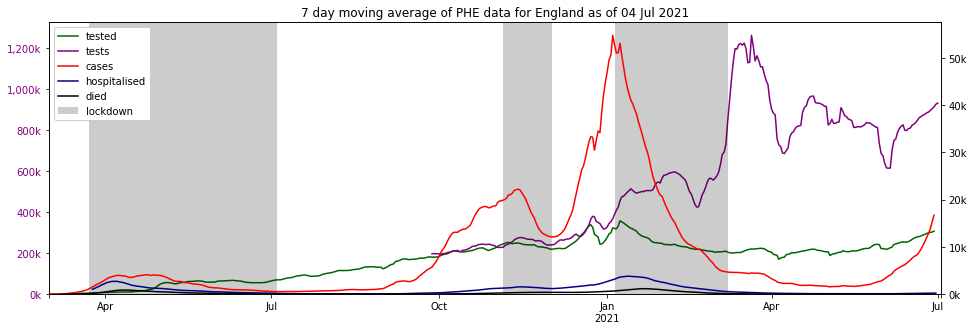

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

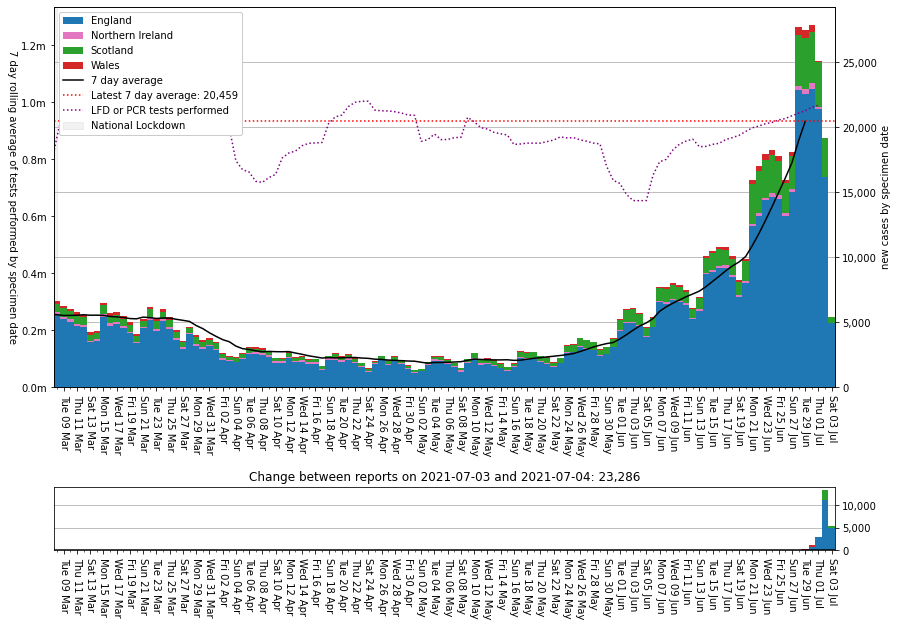

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

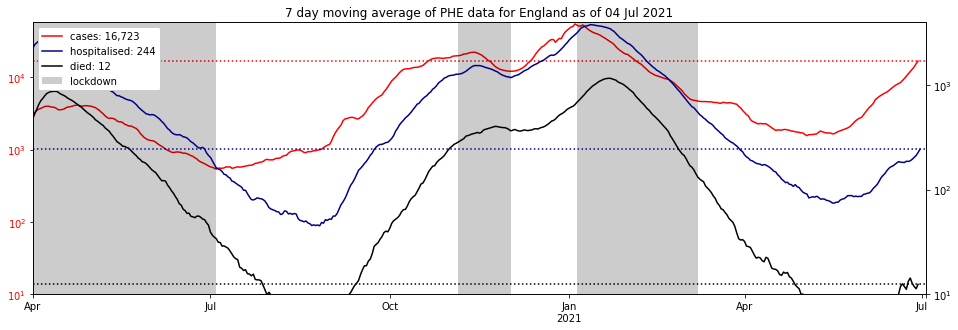

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,),
             right_series=(s.new_admissions_sum, s.new_deaths_sum))

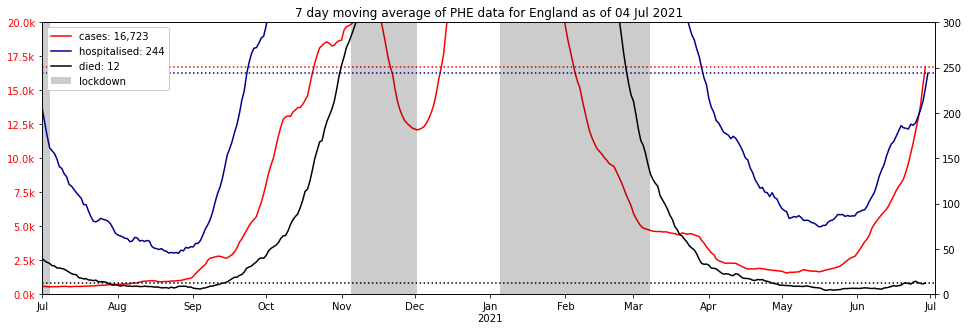

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=20_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=300)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,28238637.0,37981485.0,9742848.0,56286961,50.169056,17.309245,32.521699
1,Northern Ireland,N92000002,890335.0,1171653.0,281318.0,1893667,47.016450,14.855727,38.127823
2,Scotland,S92000003,2762156.0,3857584.0,1095428.0,5463300,50.558380,20.050665,29.390954
3,Wales,W92000004,1723824.0,2263775.0,539951.0,3152879,54.674601,17.125649,28.199750


'partial: 45,274,497 (67.8%), full: 33,614,952'

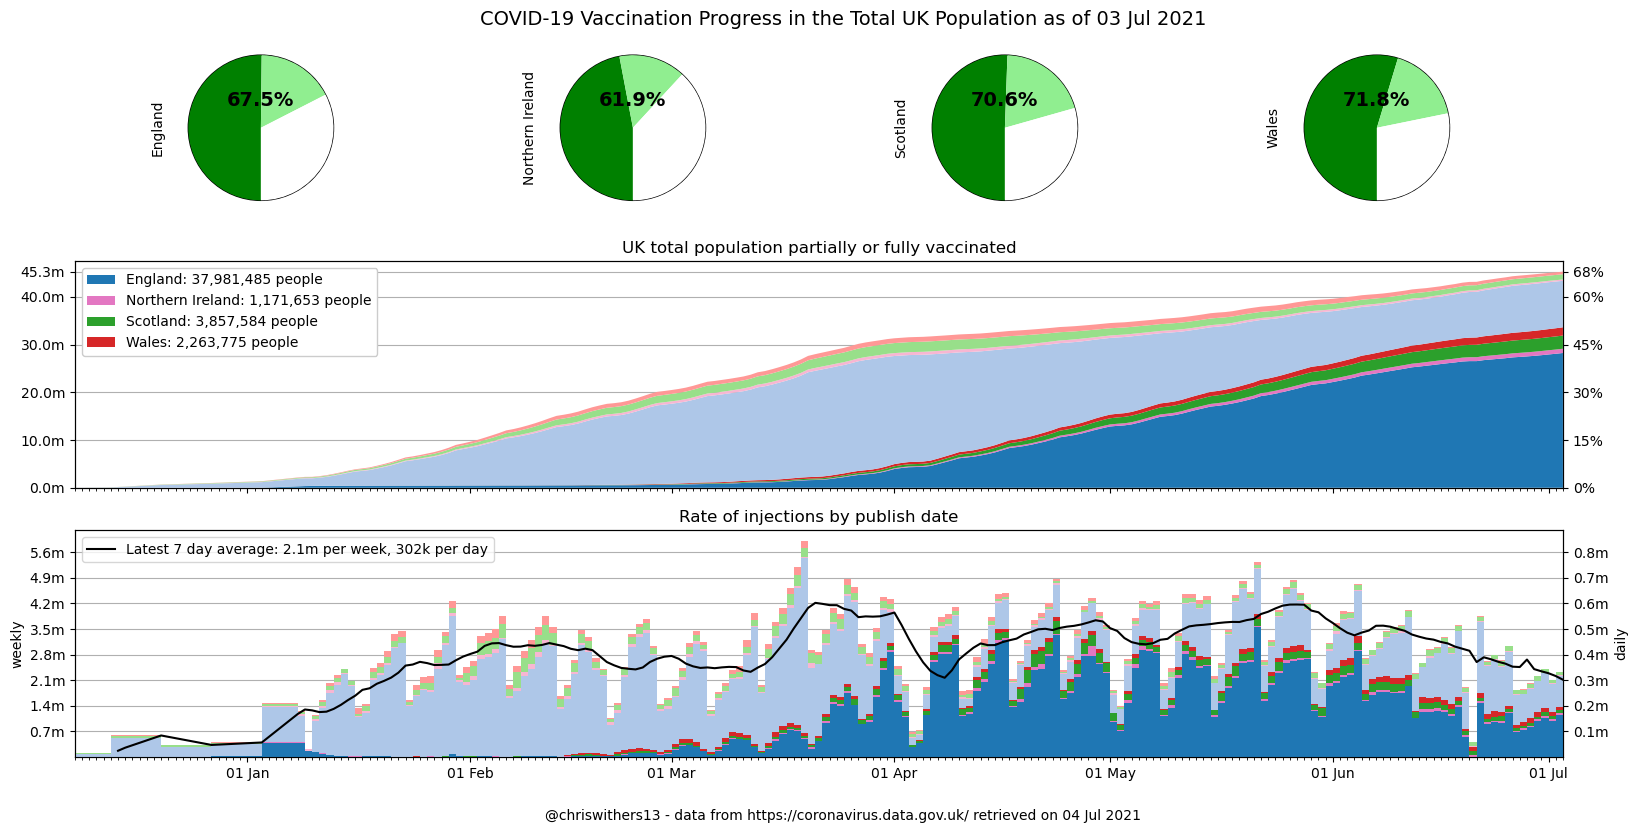

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

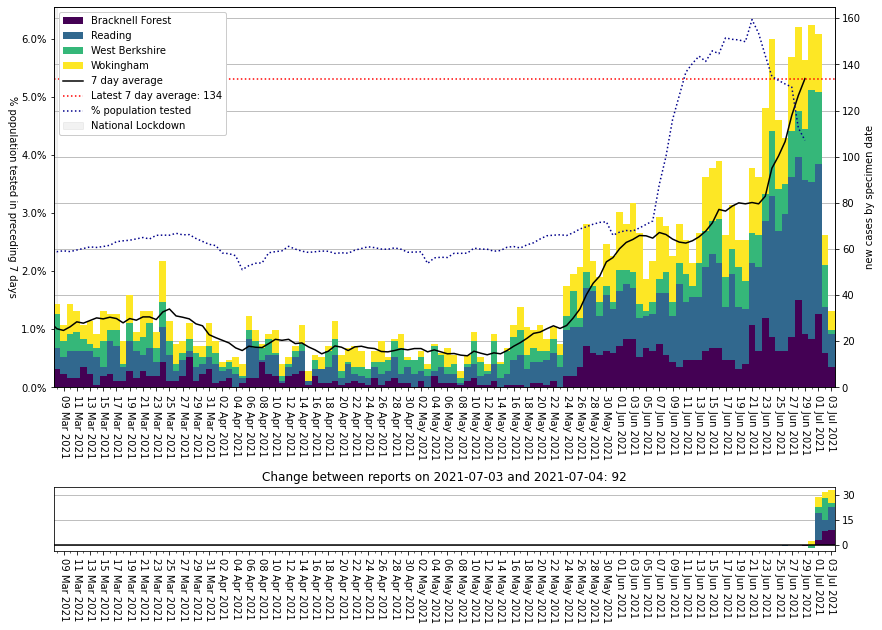

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

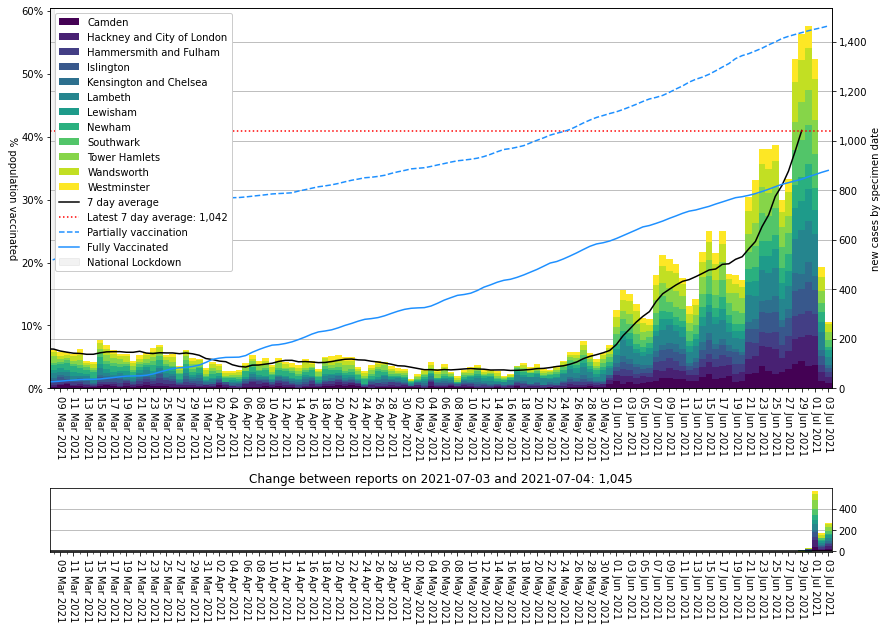

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000042,Dundee City,827.082775,1235.0,2021-07-03
E08000023,South Tyneside,725.943196,1096.0,2021-07-03
E07000199,Tamworth,687.128403,527.0,2021-07-03
S12000019,Midlothian,682.457279,631.0,2021-07-03
E08000021,Newcastle upon Tyne,660.788587,2001.0,2021-07-03
E08000037,Gateshead,639.429858,1292.0,2021-07-03
E08000024,Sunderland,614.681046,1707.0,2021-07-03
E06000012,North East Lincolnshire,590.989139,943.0,2021-07-03
S12000010,East Lothian,560.276403,600.0,2021-07-03


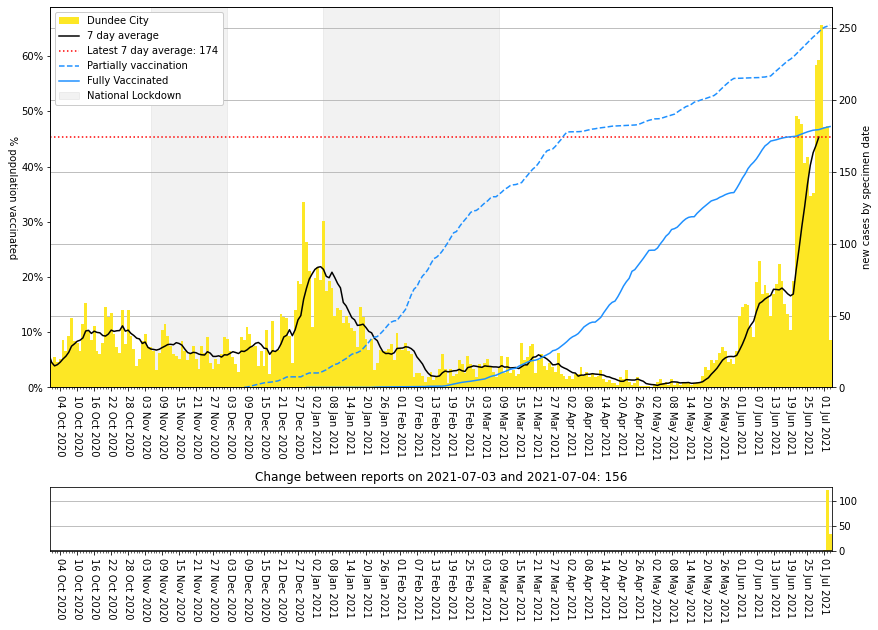

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,410.772891,3258.0,2021-07-03
E06000047,County Durham,559.146114,2964.0,2021-07-03
E08000025,Birmingham,257.221829,2937.0,2021-07-03
S12000049,Glasgow City,449.519838,2846.0,2021-07-03
S12000036,City of Edinburgh,525.974892,2761.0,2021-07-03
E08000003,Manchester,468.474726,2590.0,2021-07-03
E08000012,Liverpool,441.328241,2198.0,2021-07-03
E08000021,Newcastle upon Tyne,660.788587,2001.0,2021-07-03
E06000023,"Bristol, City of",381.546775,1768.0,2021-07-03


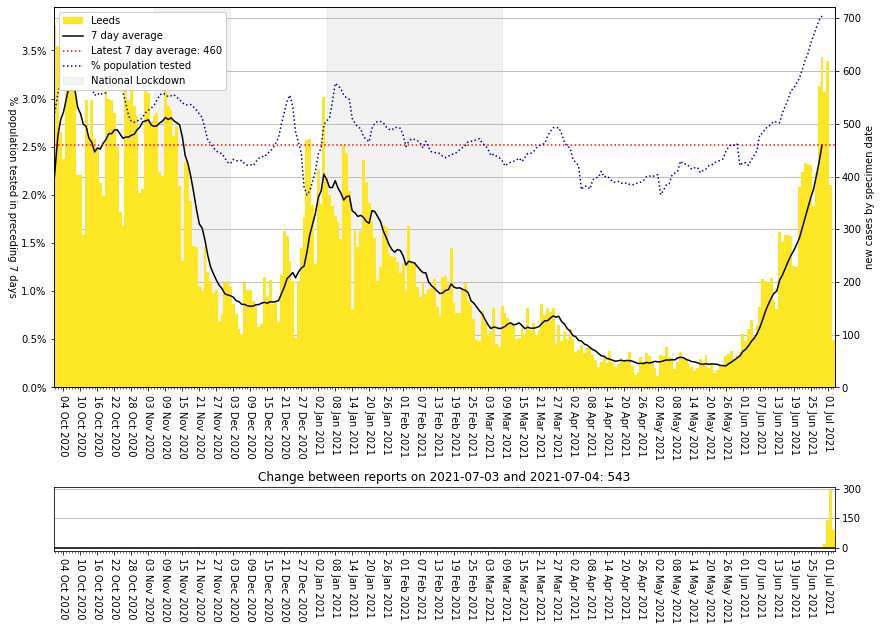

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.7

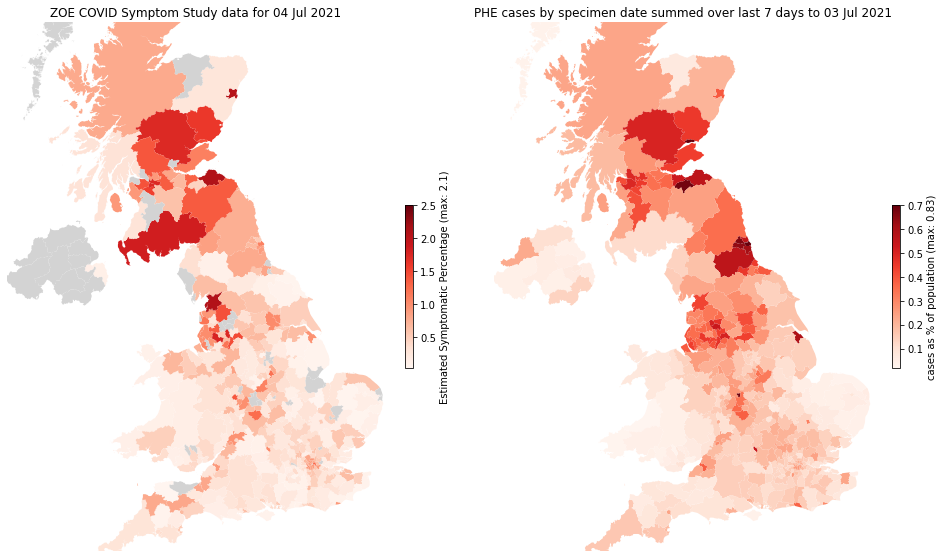

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...